In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2

env: CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2


In [2]:
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
import random
from timm.optim import Mars
from types import SimpleNamespace
from IPython.display import HTML
from types import SimpleNamespace
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop
from torchvision.transforms.v2.functional import pil_to_tensor, to_pil_image
from decord import VideoReader
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [3]:
device = "cuda"
dataset = datasets.load_dataset("danjacobellis/davis").cast_column('video',datasets.Video()).with_format("torch")

In [4]:
checkpoint = torch.load('../../hf/dance/video_f8c48_24f.pth', map_location="cpu",weights_only=False)
config = checkpoint['config']
state_dict = checkpoint['state_dict']
model = AutoCodecND(
    dim=3,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)
model.load_state_dict(state_dict)
model.eval();

In [5]:
from itertools import product

def decode_chunked(l,m,c,d,b,s,o,u):
    t,h,w=l.shape[2:]
    p=[x*c.F for x in [t,h,w]]
    x=torch.zeros([1,3]+p,device=d)
    n=[max(((x-b)//s)+1,1)for x in [t,h,w]]
    for k in product(*[range(x)for x in n]):
        st=[k[i]*s if n[i]>1 else 0 for i in range(3)]
        e=[min(st[i]+b,[t,h,w][i])for i in range(3)]
        sz=[e[i]-st[i]for i in range(3)]
        pl=[(b-sz[i])//2 if sz[i]<b else 0 for i in range(3)]
        pr=[b-sz[i]-pl[i] if sz[i]<b else 0 for i in range(3)]
        sc=[o*u if n[i]>1 else pl[i]*u for i in range(3)]
        ec=[sc[i]+(s if n[i]>1 else sz[i])*u for i in range(3)]
        so=[(st[i]+o if n[i]>1 else 0)*u for i in range(3)]
        eo=[so[i]+(s if n[i]>1 else sz[i])*u for i in range(3)]
        lb=l[:,:,st[0]:e[0],st[1]:e[1],st[2]:e[2]]
        pd=tuple(pl[2-i//2] if i%2==0 else pr[2-i//2] for i in range(6))
        if any(pd):lb=torch.nn.functional.pad(lb,pd,mode="reflect")
        with torch.no_grad():xb=m.decode(lb).clamp(-1,1)
        cp=xb[:,:,sc[0]:ec[0],sc[1]:ec[1],sc[2]:ec[2]]
        x[:,:,so[0]:eo[0],so[1]:eo[1],so[2]:eo[2]]=cp
    return x,*p

In [ ]:
overlap = 1
stride = 7
block_size = stride + 2 * overlap
target_w = 1920
target_h = 1080
upsampling_factor = config.F
overlap_pixels = overlap * upsampling_factor  # e.g., 4 * 8 = 32
central_size_pixels = stride * upsampling_factor  # e.g., 16 * 8 = 128

def pad3d(x, p, extra, small_dim_mode):
    b, c, f, h, w = x.shape
    for dim, size in zip(['f', 'h', 'w'], [f, h, w]):
        if small_dim_mode and size < p:
            pad1 = extra
            pad2 = extra
        else:
            t = math.ceil(size / p) * p
            pad_total = t - size
            pad1 = pad_total // 2
            pad2 = pad_total - pad1
            pad1 += extra
            pad2 += extra
        if dim == 'f':
            fp1, fp2 = pad1, pad2
        elif dim == 'h':
            hp1, hp2 = pad1, pad2
        elif dim == 'w':
            wp1, wp2 = pad1, pad2
    return torch.nn.functional.pad(
        x,
        pad=(wp1, wp2, hp1, hp2, fp1, fp2),
        mode="reflect"
    )

PSNR_list = []
CR_list = []
pb = progress_bar(dataset['train'])
for sample in pb:
    video = sample['video']
    len_video = len(video)
    xr = video.get_batch(range(len_video))
    xr = einops.rearrange(xr, 'f h w c -> c f h w')
    x = []
    for i_frame in range(xr.shape[1]):
        frame = xr[:, i_frame]
        pil_img = to_pil_image(frame)
        resized_img = pil_img.resize((target_w, target_h))
        tensor_frame = pil_to_tensor(resized_img).unsqueeze(1)
        x.append(tensor_frame)
    x = torch.cat(x, dim=1).unsqueeze(0)
    x = x / 127.5 - 1.0
    x = x.to(device)
    x_orig = x.clone()
    x = pad3d(x, p=config.F*stride, extra=config.F*overlap, small_dim_mode=False)
    
    with torch.no_grad():
        z = model.encode(x)
        latent = model.quantize.compand(z).round()

    # Decode using the function
    x_hat, F_padded, H_padded, W_padded = decode_chunked(
        l=latent,
        m=model,
        c=config,
        d=device,
        b=block_size,
        s=stride,
        o=overlap,
        u=config.F
    )
    
    # Crop to original dimensions
    f_start = (F_padded - len_video) // 2
    h_start = (H_padded - target_h) // 2
    w_start = (W_padded - target_w) // 2
    x_hat = x_hat[:, :,
                  f_start:f_start + len_video,
                  h_start:h_start + target_h,
                  w_start:w_start + target_w]
    x_hat = x_hat.clamp(-1, 1)

    x_orig_01 = x_orig / 2 + 0.5
    x_hat_01 = x_hat / 2 + 0.5
    PSNR = []
    for i_frame in range(x_orig_01.shape[2]):
        mse = torch.nn.functional.mse_loss(x_orig_01[0, :, i_frame], x_hat_01[0, :, i_frame])
        PSNR.append(-10 * mse.log10().item())
    PSNR_list.append(PSNR)

    size_bytes = 0
    for chunk in latent_to_pil(einops.rearrange(z[0], 'c f h w -> f c h w').cpu(),n_bits=8,C=3):
        buff = io.BytesIO()
        chunk.save(buff,format='webp',lossless=True)
        size_bytes += len(buff.getbuffer())
    CR_list.append(x_orig.numel()/size_bytes)

    pb.comment = (f"PSNR: {np.mean(PSNR)}, CR:{CR_list[-1]}")

In [7]:
display(HTML(pb.progress))

In [8]:
np.mean(CR_list)

47.92872279473821

In [9]:
np.mean([np.mean(per_frame_psnr) for per_frame_psnr in PSNR_list])

26.27859869737432

In [12]:
np.argmin([np.mean(per_frame_psnr) for per_frame_psnr in PSNR_list])

75

In [38]:
np.min([np.mean(per_frame_psnr) for per_frame_psnr in PSNR_list])

21.69254720211029

In [30]:
np.argmax([np.mean(per_frame_psnr) for per_frame_psnr in PSNR_list])

60

In [39]:
np.max([np.mean(per_frame_psnr) for per_frame_psnr in PSNR_list])

31.849646775618844

In [13]:
sample = dataset['train'][75]
video = sample['video']
len_video = len(video)
xr = video.get_batch(range(len_video))
xr = einops.rearrange(xr, 'f h w c -> c f h w')
x = []
for i_frame in range(xr.shape[1]):
    frame = xr[:, i_frame]
    pil_img = to_pil_image(frame)
    resized_img = pil_img.resize((target_w, target_h))
    tensor_frame = pil_to_tensor(resized_img).unsqueeze(1)
    x.append(tensor_frame)
x = torch.cat(x, dim=1).unsqueeze(0)
x = x / 127.5 - 1.0
x = x.to(device)
x_orig = x.clone()
x = pad3d(x, p=config.F*stride, extra=config.F*overlap, small_dim_mode=False)

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()

# Decode using the function
x_hat, F_padded, H_padded, W_padded = decode_chunked(
    l=latent,
    m=model,
    c=config,
    d=device,
    b=block_size,
    s=stride,
    o=overlap,
    u=config.F
)

# Crop to original dimensions
f_start = (F_padded - len_video) // 2
h_start = (H_padded - target_h) // 2
w_start = (W_padded - target_w) // 2
x_hat = x_hat[:, :,
              f_start:f_start + len_video,
              h_start:h_start + target_h,
              w_start:w_start + target_w]
x_hat = x_hat.clamp(-1, 1)

x_orig_01 = x_orig / 2 + 0.5
x_hat_01 = x_hat / 2 + 0.5
PSNR = []
for i_frame in range(x_orig_01.shape[2]):
    mse = torch.nn.functional.mse_loss(x_orig_01[0, :, i_frame], x_hat_01[0, :, i_frame])
    PSNR.append(-10 * mse.log10().item())

size_bytes = 0
for chunk in latent_to_pil(einops.rearrange(z[0], 'c f h w -> f c h w').cpu(),n_bits=8,C=3):
    buff = io.BytesIO()
    chunk.save(buff,format='webp',lossless=True)
    size_bytes += len(buff.getbuffer())

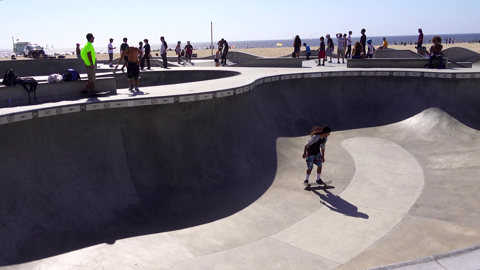

In [31]:
to_pil_image(x_orig[0,:,5]/2+0.5).resize((1920//4,1080//4))

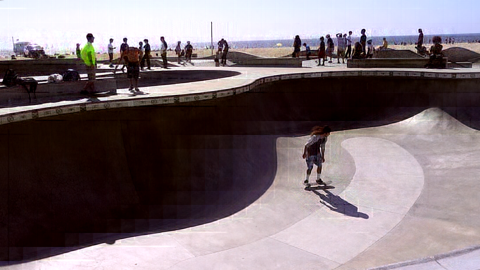

In [32]:
to_pil_image(x_hat[0,:,5]/2+0.5).resize((1920//4,1080//4))

In [33]:
sample = dataset['train'][60]
video = sample['video']
len_video = len(video)
xr = video.get_batch(range(len_video))
xr = einops.rearrange(xr, 'f h w c -> c f h w')
x = []
for i_frame in range(xr.shape[1]):
    frame = xr[:, i_frame]
    pil_img = to_pil_image(frame)
    resized_img = pil_img.resize((target_w, target_h))
    tensor_frame = pil_to_tensor(resized_img).unsqueeze(1)
    x.append(tensor_frame)
x = torch.cat(x, dim=1).unsqueeze(0)
x = x / 127.5 - 1.0
x = x.to(device)
x_orig = x.clone()
x = pad3d(x, p=config.F*stride, extra=config.F*overlap, small_dim_mode=False)

with torch.no_grad():
    z = model.encode(x)
    latent = model.quantize.compand(z).round()

# Decode using the function
x_hat, F_padded, H_padded, W_padded = decode_chunked(
    l=latent,
    m=model,
    c=config,
    d=device,
    b=block_size,
    s=stride,
    o=overlap,
    u=config.F
)

# Crop to original dimensions
f_start = (F_padded - len_video) // 2
h_start = (H_padded - target_h) // 2
w_start = (W_padded - target_w) // 2
x_hat = x_hat[:, :,
              f_start:f_start + len_video,
              h_start:h_start + target_h,
              w_start:w_start + target_w]
x_hat = x_hat.clamp(-1, 1)

x_orig_01 = x_orig / 2 + 0.5
x_hat_01 = x_hat / 2 + 0.5
PSNR = []
for i_frame in range(x_orig_01.shape[2]):
    mse = torch.nn.functional.mse_loss(x_orig_01[0, :, i_frame], x_hat_01[0, :, i_frame])
    PSNR.append(-10 * mse.log10().item())

size_bytes = 0
for chunk in latent_to_pil(einops.rearrange(z[0], 'c f h w -> f c h w').cpu(),n_bits=8,C=3):
    buff = io.BytesIO()
    chunk.save(buff,format='webp',lossless=True)
    size_bytes += len(buff.getbuffer())

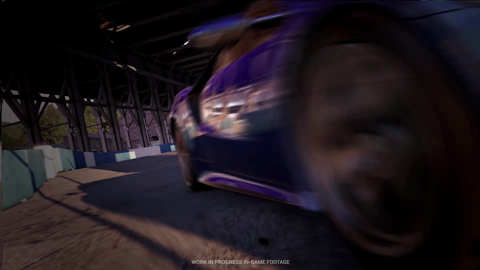

In [52]:
to_pil_image(x_orig[0,:,41]/2+0.5).resize((1920//4,1080//4))

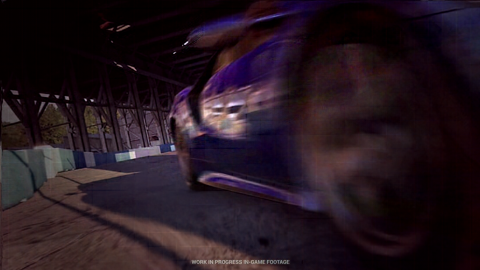

In [51]:
to_pil_image(x_hat[0,:,41]/2+0.5).resize((1920//4,1080//4))